**Chapter 7 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/add-kaggle-badge/07_ensemble_learning_and_random_forests.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [66]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# loading dataset
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    bitch = None
    with open(filename, "rb") as inp:
        bitch = pickle.load(inp)
        inp.close()
    return bitch

In [2]:
%config Completer.use_jedi = False

# Voting classifiers

In [12]:
import numpy as np
import matplotlib.pyplot as plt

heads_proba = 0.51
# creating 10 series of biased coin tosses, each with 10000 tosses
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
# np.cumsum is commulative sum
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


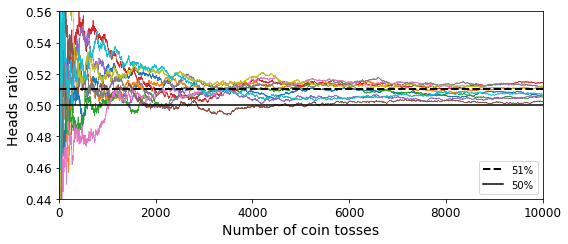

In [13]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio, linewidth=.7)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.44, 0.56])
save_fig("law_of_large_numbers_plot")
plt.show()

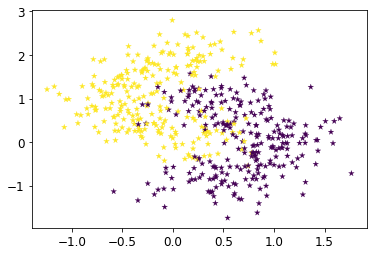

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X[:,1], X[:,0], marker="*", linewidths=.2, c=y,);

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [24]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [25]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### What about other metrics?

**Note**: the results in this notebook may differ slightly from the book, as Scikit-Learn algorithms sometimes get tweaked.

Soft voting(<font color="purple">You must ensure that all classifiers can estimate class probabilities. This is not the case of the vanilla SVC, so you need to set its `probability` hyperparameter to `True`(This will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method)</font>):

In [26]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [27]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging ensembles

<div class="alert alert-info">
One way to get a diverse set of classifiers is to use very different training algorithms,
as just discussed. Another approach is to use the same training algorithm for every
predictor and train them on different random subsets of the training set. When sampling is performed with replacement, this method is called bagging1 (short for bootstrap
aggregating2). When sampling is performed without replacement, it is called
pasting.3
In other words, both bagging and pasting allow training instances to be sampled several
times across multiple predictors, but only bagging allows training instances to be
sampled several times for the same predictor.

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [30]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [34]:
pas_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,\
                           max_samples=100, bootstrap=False, random_state=42)
pas_clf.fit(X_train, y_train)
y_pred_pas = pas_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_pas))

0.92


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability=1)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_voting))

0.92


In [31]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


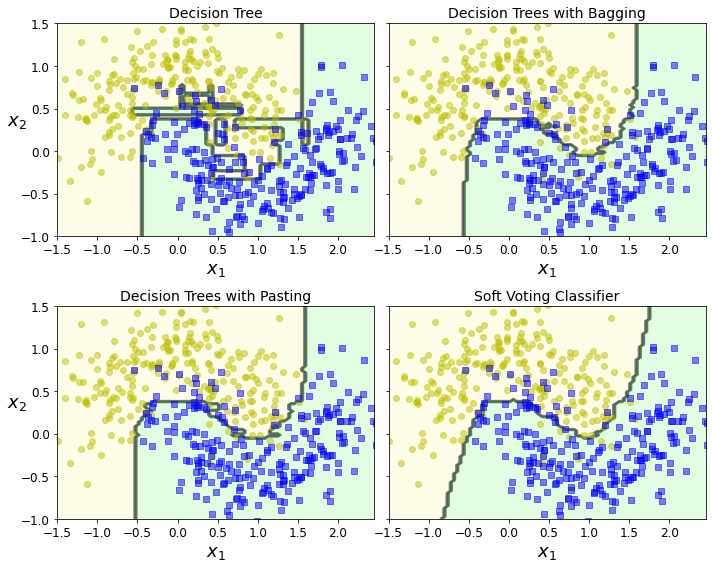

In [38]:
fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharey=True)
plt.sca(axes[0][0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[0][1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.sca(axes[1][0])
plot_decision_boundary(pas_clf, X, y)
plt.title("Decision Trees with Pasting", fontsize=14)
plt.sca(axes[1][1])
plot_decision_boundary(voting_clf, X, y)
plt.title("Soft Voting Classifier", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

<div class="alert alert-info">
This figure compares the decision boundary of a single Decision Tree with the decision
boundary of a bagging ensemble of 500 trees (from the preceding code), a pasting ensemble of 500 trees, and lastly the soft voting classifier we built earlier, all of them
trained on the moons dataset. As you can see, the ensembles’ predictions will likely
generalize much better than the single Decision Tree’s predictions: the ensembles have a
comparable bias but a smaller variance (they make roughly the same number of errors
on the training set, but the decision boundaries are less irregular).
    
<div class="alert alert-warning">
Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting; but the extra
diversity also means that the predictors end up being less correlated, so the ensemble’s
variance is reduced. Overall, bagging often results in better models, which explains
why it is generally preferred. However, if you have spare time and CPU power, you
can use cross-validation to evaluate both bagging and pasting and select the one that
works best.
    
</div></div>

## Out-of-Bag evaluation

In [39]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [40]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [41]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## Random Patches and Random Subspaces

# Random Forests

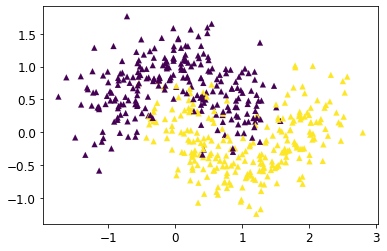

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, marker="^", linewidths=.1);

In [54]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [55]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [56]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [57]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

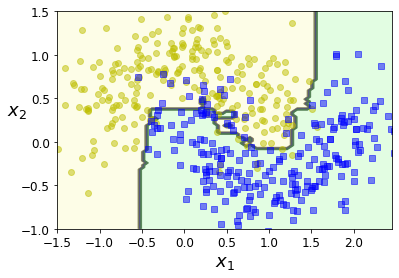

In [58]:
plot_decision_boundary(rnd_clf, X, y)

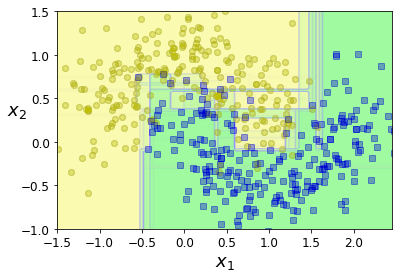

In [63]:
plt.figure(figsize=(6, 4))

for i in range(20):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Extra-Trees

**Ext**remely **Ra**ndomized **Trees** ensemble (or Extra-Trees for short) is a more randomized version of Random Forests with the following differences:

- **Random forest uses bootstrap replicas**, that is to say, it subsamples the input data with replacement, whereas **Extra Trees use the whole original sample**. In the Extra Trees sklearn implementation there is an optional parameter that allows users to bootstrap replicas, but by default, it uses the entire input sample. This may increase variance because bootstrapping makes it more diversified.
- Another difference is **the selection of cut points** in order to split nodes. **Random Forest chooses the optimum split while Extra Trees chooses it randomly**. However, once the split points are selected, the two algorithms choose the best one between all the subset of features. Therefore, Extra Trees adds randomization but still has optimization.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

## Feature importance

In [59]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [60]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

<div class="alert alert-warning">
<font color="purple">

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [42]:
# from sklearn.datasets import fetch_openml

# mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# mnist.target = mnist.target.astype(np.uint8)

Or use `pickle`:

In [67]:
mnist = load_object("datasets/mnist.pkl")

<div class="alert alert-danger">
Gonna take a bit!

In [74]:
import time
t0 = time.time()
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])
print("Time elapsed:", time.strftime("%H:%M:%S",time.gmtime(time.time() - t0)))

Time elapsed: 00:01:25


In [75]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


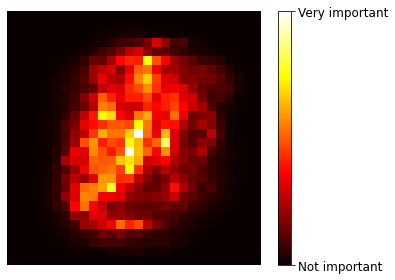

In [76]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting

## AdaBoost

<div class="alert alert-success">

AdaBoost algorithm goes as follows. Each instance weight $w^{(i)}$ is initially set to $\frac1m$, then the first predictor is trained and its weighted *error rate $r_1$* is computed as follows:

$$r_j = \frac{\sum^m_{
\begin{array} & i=1 \\
\hat{y}_j^{(i)} \ne y^{(i)}
\end{array}}w^{(i)}}{\sum_{i=1}^m w^{(i)}}$$
where $\hat{y}^{(i)}_j$ is the $j^{\text{th}}$  predictor's prediction for the $i^{\text{th}}$ instance. Then it comes *predictor's weight* $\alpha_j$:
$$\alpha_j = \eta\log\frac{1-r_j}{r_j}$$
Next the instance weights are updated:
$$w^{(i)}\leftarrow\begin{cases}w^{(i)} \qquad\quad\quad\text{if}\, \space\hat{y}_j^{(i)} = y^{(i)} \\ w^{(i)}\exp(\alpha_j)\quad\, \text{if}\,\space\hat{y}_j^{(i)} \ne y^{(i)}\end{cases}$$
for $i=1,2,...,m$

Saving figure boosting_plot


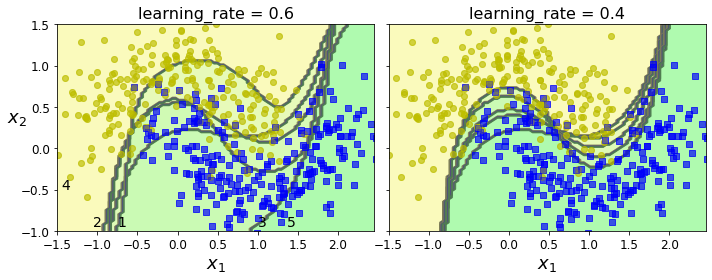

In [89]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, .6), (1, 0.4)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [90]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

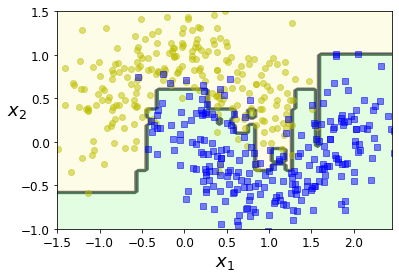

In [91]:
plot_decision_boundary(ada_clf, X, y)

## Gradient Boosting

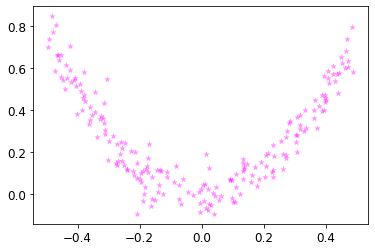

In [106]:
np.random.seed(42)
X = np.random.rand(200, 1) - 0.5
y = 3*X[:, 0]**2 + 0.07 * np.random.randn(200)
plt.scatter(X, y, marker="*", color="magenta", alpha=0.4, linewidths=0.2);

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

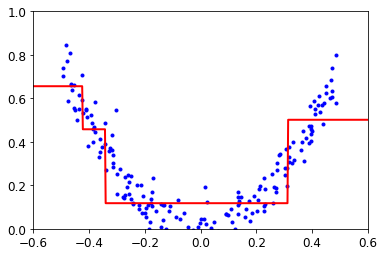

In [120]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)
plot_predictions([tree_reg1], X, y, axes=[-0.6, 0.6, 0, 1]);

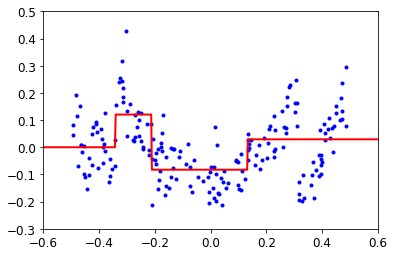

In [127]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)
plot_predictions([tree_reg2], X, y2, axes=[-0.6, 0.6, -0.3, 0.5]);

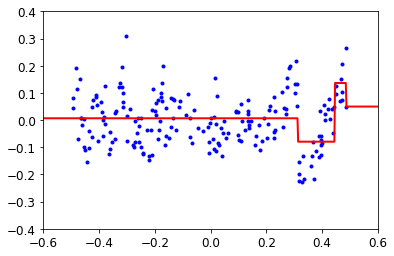

In [126]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)
plot_predictions([tree_reg3], X, y3, axes=[-0.6, 0.6, -0.4, 0.4]);

In [110]:
X_new = np.array([[0.8]])

In [111]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [114]:
y_pred, 3 * X_new ** 2 + + 0.07 * np.random.randn(1)

(array([0.5804681]), array([[1.98003617]]))

Saving figure gradient_boosting_plot


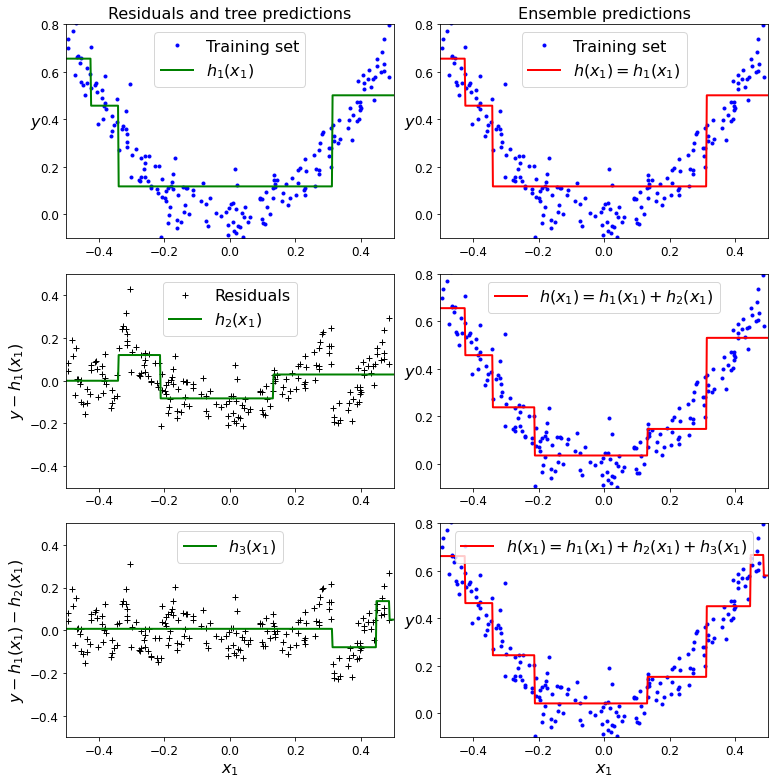

In [128]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [129]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [146]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

gbrt_slow1 = GradientBoostingRegressor(max_depth=2, n_estimators=400, learning_rate=0.03, min_samples_leaf=20, random_state=42)
gbrt_slow1.fit(X, y)

gbrt_slow2 = GradientBoostingRegressor(max_depth=2, min_samples_leaf=10, n_estimators=2000, learning_rate=0.01, random_state=42)
gbrt_slow2.fit(X, y)

GradientBoostingRegressor(learning_rate=0.01, max_depth=2, min_samples_leaf=10,
                          n_estimators=2000, random_state=42)

Saving figure gbrt_learning_rate_plot


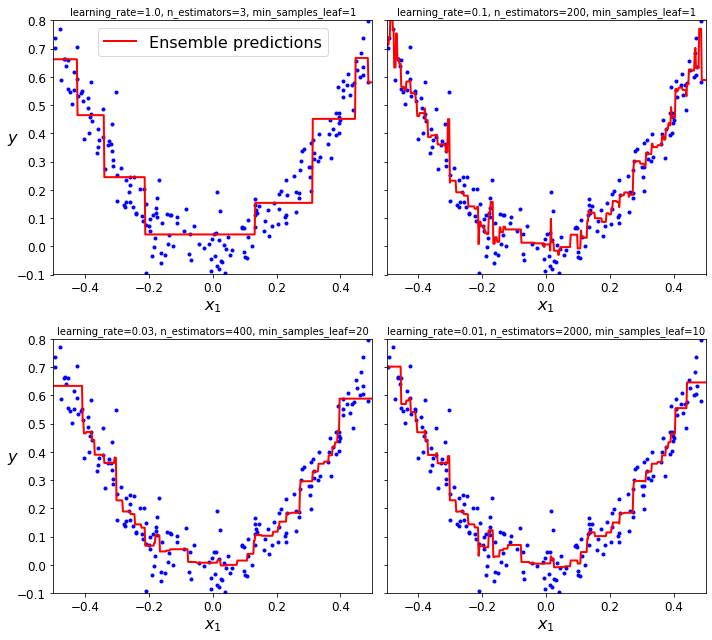

In [148]:
fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,9), sharey=True)

plt.sca(axes[0][0])
plot_predictions([gbrt], X, y, \
                 axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}, min_samples_leaf={}"\
          .format(gbrt.learning_rate,\
                  gbrt.n_estimators,\
                  gbrt.min_samples_leaf),
          fontsize=10)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[0][1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}, min_samples_leaf={}"\
          .format(gbrt_slow.learning_rate, \
                  gbrt_slow.n_estimators,\
                 gbrt_slow.min_samples_leaf), \
          fontsize=10)
plt.xlabel("$x_1$", fontsize=16)

plt.sca(axes[1][0])
plot_predictions([gbrt_slow1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], )
plt.title("learning_rate={}, n_estimators={}, min_samples_leaf={}"\
          .format(gbrt_slow1.learning_rate, \
                  gbrt_slow1.n_estimators,\
                 gbrt_slow1.min_samples_leaf), \
          fontsize=10)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1][1])
plot_predictions([gbrt_slow2], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}, min_samples_leaf={}"\
          .format(gbrt_slow2.learning_rate,\
                  gbrt_slow2.n_estimators,\
                 gbrt_slow2.min_samples_leaf),\
          fontsize=10)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

<div class="alert alert-warning">Look at the poor predictions (underfitting) happening at the edges.</div>

## Gradient Boosting with Early stopping

In [149]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=61, random_state=42)

In [150]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


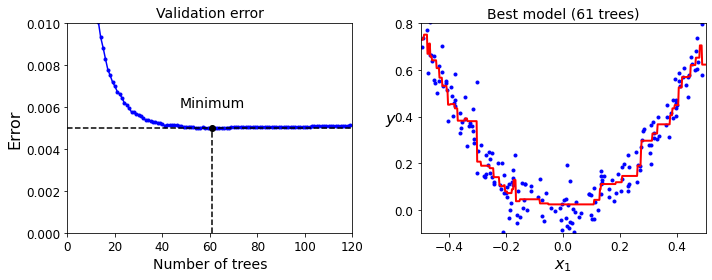

In [151]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [152]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [153]:
print(gbrt.n_estimators)

47


In [154]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.005130124870445556


### Stochastic Gradient Boosting

## Using XGBoost

In [50]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [51]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.00400040950714611


In [52]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

Validation MSE: 0.0026308690413069744


In [53]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

76.1 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

20.8 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Stacking

In [155]:
sklearn.__version__

'0.24.1'

<div class="alert alert-warning">
Up to `sklearn==0.24.1` there is no support for stacking, however you can roll out your own implementation(check out exercises), or check other open source implementatins such as `brew`.

# Extra Materials

# Extra Materials

<input type="checkbox"/> [XGBoost by Matt Harrison](extras/09.XGboost.ipynb)</input><br>

- <a href="https://www.kaggle.com/paulrohan2020/tutorial-lightgbm-xgboost-catboost-top-11">Tutorial LightGBM + XGBoost + CatBoost (Top 11%)</a>

- <a href="https://www.kdnuggets.com/2020/06/lightgbm-gradient-boosting-decision-tree.html">LightGBM: A Highly-Efficient Gradient Boosting Decision Tree</a>
- <a href="https://machinelearningmastery.com/implementing-stacking-scratch-python/">Stacked Generalization by Machine Learning Mastery</a>

# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [57]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [58]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [59]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [60]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9639]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [61]:
from sklearn.ensemble import VotingClassifier

In [62]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [63]:
voting_clf = VotingClassifier(named_estimators)

In [64]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [65]:
voting_clf.score(X_val, y_val)

0.9711

In [66]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9639]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [67]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

This updated the list of estimators:

In [68]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

However, it did not update the list of _trained_ estimators:

In [69]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [70]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [71]:
voting_clf.score(X_val, y_val)

0.9735

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [72]:
voting_clf.voting = "soft"

In [73]:
voting_clf.score(X_val, y_val)

0.9693

Nope, hard voting wins in this case.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [74]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9706

In [75]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9624]

The voting classifier only very slightly reduced the error rate of the best model in this case.

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [76]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [77]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [78]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [79]:
rnd_forest_blender.oob_score_

0.9689

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [80]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [81]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [82]:
from sklearn.metrics import accuracy_score

In [83]:
accuracy_score(y_test, y_pred)

0.9683

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.